In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from transformers import AutoTokenizer
import os
import random
import wandb
import matplotlib.pyplot as plt

/home/ritish/prog/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# import pytorch datasets
from torchvision import datasets as Datasets
from torchvision import transforms

cifar10_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

cifar10_val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

#  loading training data
training_set = Datasets.CIFAR10(root='../../autoencoder/', download=True, transform=cifar10_train_transforms)

#  loading validation data
validation_set = Datasets.CIFAR10(root='../../autoencoder/', download=True, train=False, transform=cifar10_val_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Creating a vision transformer model from scratch
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, causal):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.causal = causal
        self.q_attn = nn.Linear(config['n_embed'], config['n_embed'], bias=False)
        self.kv_attn = nn.Linear(config['n_embed'], config['n_embed'] * 2, bias=False)
        self.c_proj = nn.Linear(config['n_embed'], config['n_embed'], bias=False)             # Combine the outputs of the heads
        self.attn_dropout = nn.Dropout(config['dropout'])
        self.resid_dropout = nn.Dropout(config['dropout'])

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        # self.flash = False

        if not self.flash:
            print("WARNING: using slow attention.")
            self.register_buffer("tril", torch.tril(torch.ones(config['block_size'], config['block_size'])))

    def forward(self, x, y=None, mask=None):
        B, T_dec, C = x.shape

        if y is None:
            y = x

        B, T_enc, C = y.shape

        # Query from the decoder
        q = self.q_attn(x).view(B, T_dec, self.num_heads, self.head_size).transpose(1, 2)  # (B,T_dec,C) -> (B,T_dec,nh,hs) -> (B,nh,T_dec,hs)
        k, v = self.kv_attn(y).split(C, dim=-1)                                 # (B,T_enc,2C) -> 2*(B,T_enc,C)
        k = k.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)
        v = v.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)

        if self.flash:
            out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=self.causal)
        else:
            wei = q @ k.transpose(-2, -1) * 1.0 / math.sqrt(k.size(-1))         # (B,nh,T_dec,hs) @ (B,nh,hs,T_enc) -> (B,nh,T_dec,T_enc)
            if self.causal:
                if mask is None:
                    # Lower triangular mask to mask future tokens
                    wei = wei.masked_fill(self.tril[:T_dec, :T_enc] == 0, float('-inf')) # (B,nh,T_dec,T_enc)
                else:
                    wei = wei.masked_fill(mask == 0, float('-inf'))             # (B,nh,T_dec,T_enc)
            wei = F.softmax(wei, dim=-1)                                        # (B,nh,T_dec,T_enc)
            wei = self.attn_dropout(wei)
            out = wei @ v                                                       # (B,nh,T_dec,T_enc) @ (B,nh,T_enc,hs) -> (B,nh,T_dec,hs)

        out = out.transpose(1, 2).contiguous().view(B, T_dec, -1)               # (B,T_dec,nh*hs) = (B,T_dec,C)
        return self.resid_dropout(self.c_proj(out))

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.GELU(),
            # nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        return self.net(x)

class EncoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head):
        # n_embed: embedding dimension, nhead: the number of heads we'd like
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, causal=False)
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class DecoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head, cross=False):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.cross = cross
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, causal=True)               # Masked MHA
        if self.cross:
            # Cross attention block
            self.cross_sa = MultiHeadAttention(n_head, head_size, causal=False,)     # Cross MHA
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

    def forward(self, x, y=None):
        x = x + self.sa(self.ln1(x))
        if self.cross:
            x = x + self.cross_sa(self.ln2(x), y)
        x = x + self.ffwd(self.ln3(x))
        return x

class PatchEmbeddingsConv(nn.Module):
    """ Extracting patches and then projecting the patches """

    def __init__(self, img_size, patch_size, in_chans, n_embed):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patch = (img_size // patch_size) ** 2
        self.conv = nn.Conv2d(in_chans, n_embed, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"
        x = self.conv(x).flatten(2).transpose(1, 2)     # (B, n_embed, n_patch)
        return x

class PatchEmbeddingsLinear(nn.Module):
    """ Extracting patches and then projecting the patches """

    def __init__(self, img_size, patch_size, in_chans, n_embed):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patch = (img_size // patch_size) ** 2
        self.proj = nn.Linear(in_chans * (patch_size ** 2), n_embed)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"

        # Extract patches by folding the image across H and W
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)   # (B, C, H, W) -> (B, C, H//P, W//P, P, P)
        x = x.flatten(2, 3).transpose(1, 2)                                                             # (B, C, H//P, W//P, P, P) -> (B, H//P*W//P, C,P,P)
        x = x.flatten(2)                                                                                # (B, n_patch, C*P*P)
        return self.proj(x)                                                                             # (B, n_patch, n_embed)

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, config):
        super().__init__()
        # self.embeddings = PatchEmbeddingsLinear(image_size, patch_size, in_channels, config['n_embed'])
        self.embeddings = PatchEmbeddingsConv(image_size, patch_size, in_channels, config['n_embed'])
        n_patches = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches+1, config['n_embed']))
        self.cls_token = nn.Parameter(torch.randn(1, 1, config['n_embed']))
        self.enc_blocks = nn.Sequential(*[EncoderBlock(config['n_embed'], config['n_head']) for _ in range(config['n_layer'])])
        self.ln_f = nn.LayerNorm(config['n_embed'])
        self.MLP = nn.Sequential(
            nn.Linear(config['n_embed'], config['n_embed']),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(config['n_embed'], config['vocab_size']),
        )

    def forward(self, x, targets=None):
        x = self.embeddings(x)
        # Add cls token as a learnable parameter
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)                   # (B, 1, C)
        x = torch.cat((cls_token, x), dim=1)                                    # (B, T+1, C)
        x = x + self.pos_embedding                                              # (B, T+1, C)
        x = self.enc_blocks(x)                                                  # (B, T+1, C)

        # Only return the cls token
        x = x[:, 0, :]                                                          # (B, C)

        # Pass through final layer and get the logits
        x = self.MLP(self.ln_f(x))                                              # (B, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(x, targets.view(-1), ignore_index=0)
        return x, loss

In [ ]:
config = {
    'n_embed': 256,
    'n_head': 8,
    'n_layer': 6,
    'img_size': 32,
    'patch_size': 4,
    'block_size': 65,
    'dropout': 0.2,
    'batch_size': 64,
    'vocab_size':10,
    # 'mixed_precision': 'fp16',
    'activation' : 'gelu'
}

In [34]:
wandb.finish()

accuracy,▅▅█▁▅▁▅▁▅█▅▅▅▅▅▅█▁▅█▅▅▅▅▅▅▁▁▁▅███▅█████▁
lr,█████████████████████████████████▁▁▁▁▁▁▁
train_loss,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▁▅▅▃▅▅▅
val_loss,▇█▆▆▅▄▆▆▄▃▅▃▃▆▃▃▃▃▃▃▃▂▅▃▂▄▁▃▇▁▄▃▄▁▂▂▁▁▂▃
accuracy,0.8125
lr,3e-05
train_loss,0.33672
val_loss,0.52383


In [ ]:
wandb.init(
    project="vit_cifar10",
    entity="ritishtest1",
    id='ag41z1zl',
    resume='must',

    config=config,
)

In [5]:
# Create a model
model = VisionTransformer(image_size=32, patch_size=4, in_channels=3, config=config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = model.to(device)
n_epoch = 0
step = 0
# Print parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, 'M params')

4.83073 M params


In [6]:
n_epoch=70
step = 57000

In [7]:
# Load model
# model.load_state_dict(torch.load('vit_cifar10_test.safetensors'))

In [6]:
# Create a dataloader
train_loader = DataLoader(training_set, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(validation_set, batch_size=config['batch_size'], shuffle=False)

In [183]:
# Learning rate scheduling with warmup steps
# def lr_scheduler(step, n_embed=config['n_embed'], warmup_steps=400):
#     step = max(1, step)
#     lr = (n_embed ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
#     return lr

# optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

In [184]:
# Training loop
def train_step(model, data, optimizer):
    model.train()
    x, y = data
    # print(x.shape, y.shape)
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_hat, loss = model(x, y)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    return loss

def eval_step(model, data):
    model.eval()
    x, y = data
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_hat, loss = model(x, y)
    return loss

# Training loop
avg_train_loss = 0
eval_interval = 300
step1 = 0

for epoch in range(10):
    for data in train_loader:
        loss = train_step(model, data, optimizer)
        avg_train_loss += loss.item()
        if (step % eval_interval == 0 and step1 != 0):
            avg_train_loss /= eval_interval
            val_loss = sum(eval_step(model, data) for data in valid_loader) / len(valid_loader)
            print(f"Epoch: {n_epoch} Step {step}: train_loss {avg_train_loss:.3f} val_loss {val_loss:.3f} lr {optimizer.param_groups[0]['lr']:.1e}")

            val_acc = 0
            # Print accuracy
            for data in valid_loader:
                x, y = data
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    y_hat, _ = model(x)
                y_hat = y_hat.argmax(dim=-1)
                correct = (y_hat == y).sum().item()
                total = y.numel()
                val_acc = correct / total
            print(f"Accuracy: {val_acc:.2f}")

            # wandb.log({"train_loss": avg_train_loss, "val_loss": val_loss, "lr": optimizer.param_groups[0]['lr'], "accuracy": val_acc}, step=step)
            avg_train_loss = 0
        step += 1
        step1+= 1
    n_epoch += 1

Epoch: 81 Step 66000: train_loss 0.257 val_loss 0.521 lr 1.0e-06
Accuracy: 0.69
Epoch: 81 Step 66200: train_loss 0.312 val_loss 0.520 lr 1.0e-06
Accuracy: 0.69
Epoch: 81 Step 66400: train_loss 0.319 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 81 Step 66600: train_loss 0.309 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 82 Step 66800: train_loss 0.300 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 82 Step 67000: train_loss 0.314 val_loss 0.518 lr 1.0e-06
Accuracy: 0.69
Epoch: 82 Step 67200: train_loss 0.320 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 82 Step 67400: train_loss 0.304 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 83 Step 67600: train_loss 0.301 val_loss 0.521 lr 1.0e-06
Accuracy: 0.69
Epoch: 83 Step 67800: train_loss 0.312 val_loss 0.519 lr 1.0e-06
Accuracy: 0.69
Epoch: 83 Step 68000: train_loss 0.301 val_loss 0.520 lr 1.0e-06
Accuracy: 0.69
Epoch: 84 Step 68200: train_loss 0.298 val_loss 0.521 lr 1.0e-06
Accuracy: 0.69
Epoch: 84 Step 68400: train_loss 0.306 v

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('vit_cifar10.safetensors'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4390449..1.205605].


Label: frog
Predicted: frog


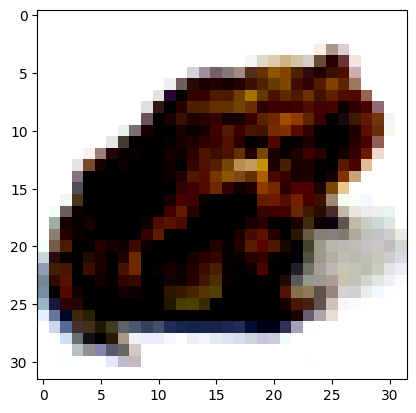

In [8]:
# Check the model
model.eval()
# x, y = next(iter(valid_loader))
# Take random image from the dataset
x, y = random.choice(validation_set)
x, y = x.unsqueeze(0), torch.tensor(y).unsqueeze(0)
x, y = x.to(device), y.to(device)
y_hat, _ = model(x)
y_hat = y_hat.argmax(dim=-1)

import matplotlib.pyplot as plt
# Denormalize and show image
def show_image(x):
    x = x.permute(1, 2, 0).cpu().numpy()
    x = (x + 1) / 2
    plt.imshow(x)
show_image(x[0])

# Print predicted class name and true class name
classes = validation_set.classes
print("Label:", classes[y[0]])
print("Predicted:", classes[y_hat[0]])

In [9]:
# Calculate validation accuracy
correct = 0
total = 0
for data in valid_loader:
    x, y = data
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_hat, _ = model(x)
    y_hat = y_hat.argmax(dim=-1)
    correct += (y_hat == y).sum().item()
    total += y.numel()
print(f"Accuracy: {correct/total:.2f}")

Accuracy: 0.76


In [ ]:
# Calculate validation accuracy
correct = 0
total = 0
for data in train_loader:
    x, y = data
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_hat, _ = model(x)
    y_hat = y_hat.argmax(dim=-1)
    correct += (y_hat == y).sum().item()
    total += y.numel()
print(f"Accuracy: {correct/total:.2f}")

In [44]:
def visualize_attention(model, x, device=device):
    model.eval()
    x = x.unsqueeze(0).to(device)
    attention_weights = []
    
    with torch.no_grad():
        x = model.embeddings(x)
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + model.pos_embedding
        
        for i, block in enumerate(model.enc_blocks):
            # Forward pass through the transformer block
            x = block(x)
            
            # Get keys, queries, and values for the current layer
            B, T_enc, C = x.shape
            q = block.sa.q_attn(x)
            k, v = block.sa.kv_attn(x).split(C, dim=-1)
            
            # Split q, k, v into multiple heads
            q = q.view(B, T_enc, block.sa.num_heads, block.sa.head_size).transpose(1, 2)
            k = k.view(B, T_enc, block.sa.num_heads, block.sa.head_size).transpose(1, 2)
            v = v.view(B, T_enc, block.sa.num_heads, block.sa.head_size).transpose(1, 2)
            
            # Compute attention weights
            attn = (q @ k.transpose(-2, -1)) / math.sqrt(k.size(-1))
            # Store the attention weights for the current layer
            attention_weights.append(attn.cpu().numpy())
            
            attn = F.softmax(attn, dim=-1)
    
    # Convert the list of attention weights to a numpy array
    attention_weights = np.array(attention_weights)
    
    return attention_weights[:, 0, :, :, :]

# Get a random image from the dataset
x, y = random.choice(validation_set)

# # Visualize attention map
attn = visualize_attention(model, x)
print(attn.shape)

(6, 8, 65, 65)


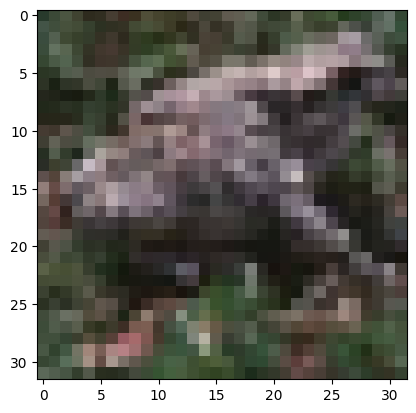

In [45]:
# Show the image
# Denormalize the image according to the CIFAR10 normalization per channel
def show_image(x):
    x = x.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.49139968, 0.48215841, 0.44653091])
    std = np.array([0.24703223, 0.24348513, 0.26158784])
    x = x * std + mean
    plt.imshow(x)
show_image(x)

In [46]:
attn_rollout = np.zeros((6, 8, 65, 65))

for layer in range(6):
    for head in range(8):
        attn_normalized = (attn[layer, head] + np.eye(attn[layer, head].shape[0])) * 0.5
        if layer == 0:
            attn_rollout[layer, head] = attn_normalized
        else:
            attn_rollout[layer, head] = attn_normalized @ attn_rollout[layer-1, head]

# Plot the attention maps
# fig, axs = plt.subplots(6, 8, figsize=(24, 18))
# for i in range(6):
#     for j in range(8):
#         axs[i, j].imshow(attn_rollout[i, j], cmap='cividis')
#         axs[i, j].axis('off')
#         axs[i, j].set_title(f'Layer {i+1}, Head {j+1}')

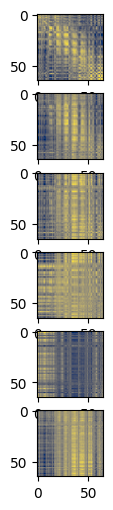

In [47]:
# Plot mean attention map across heads
fig, ax = plt.subplots(6, 1, figsize=(6, 6))
attn_mean = attn_rollout.mean(axis=1)
for i in range(6):
    ax[i].imshow(attn_mean[i], cmap='cividis')

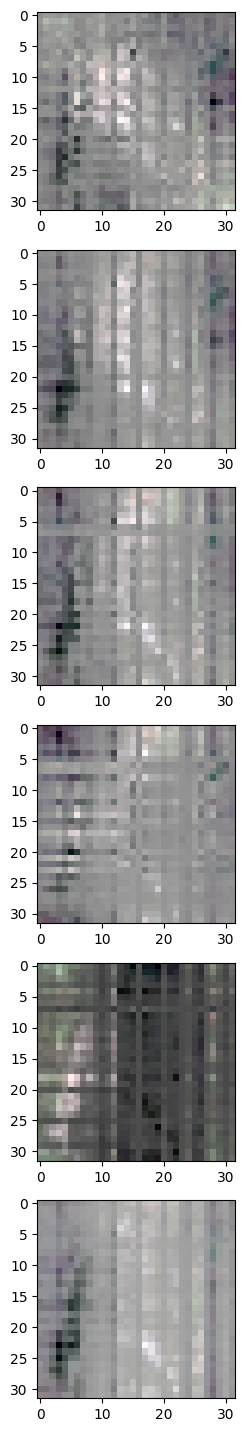

In [ ]:
import cv2

std = np.array([0.24703223, 0.24348513, 0.26158784])
mean = np.array([0.49139968, 0.48215841, 0.44653091])

mask = cv2.resize(attn_mean[3], (32, 32))
img = (mask * (x.permute(1,2,0)*std+mean).permute(2,1,0).cpu().numpy()).transpose(1,2,0) 

# Plot for all attn_mean
fig, axs = plt.subplots(6, 1, figsize=(6, 18))
for i in range(6):
    mask = cv2.resize(attn_mean[i], (32, 32))
    img = (mask * (x.permute(1,2,0)*std+mean).permute(2,1,0).cpu().numpy()).transpose(1,2,0) 
    img = (img - img.min()) / (img.max() - img.min())       # Normalize the image
    axs[i].imshow(img)

torch.Size([256, 3, 4, 4])


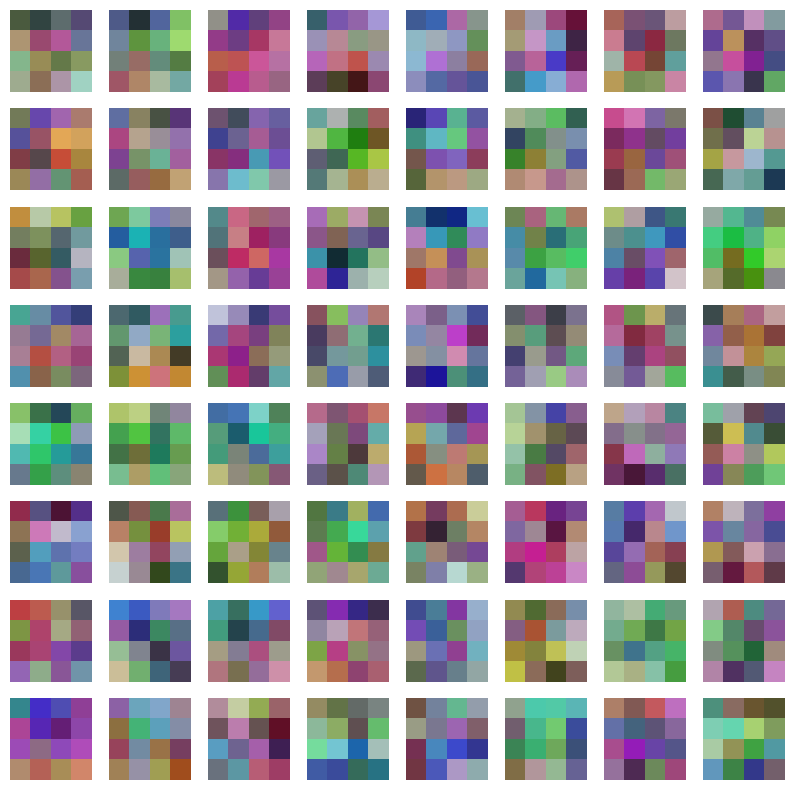

In [16]:
# Visualize conv filter of the first layer

# Get the first layer of the model
first_layer = model.embeddings.conv
# Get the weights of the first layer
weights = first_layer.weight    # (n_embed, in_channels, patch_size, patch_size)
# Normalize the weights
weights = weights - weights.min()
weights = weights / weights.max()
print(weights.shape)
# Visualize the weights
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(weights[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
plt.show()

In [26]:
# Visualize positional embeddings
import seaborn as sns
pos_embedding = model.pos_embedding.detach().squeeze(0).cpu().numpy()
pos_embedding = pos_embedding[1:].reshape(8, 8, -1)
print(pos_embedding.shape)

(8, 8, 256)


<Axes: >

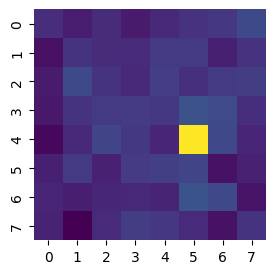

In [27]:
# Create a grid of dot product of positional embeddings
p1 = pos_embedding[4,5]

similarities = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        p2 = pos_embedding[i, j]
        similarities[i, j] = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

similarities = np.array(similarities).reshape(8, 8)
plt.figure(figsize=(3,3))
sns.heatmap(similarities, annot=False, cmap='viridis', cbar=False)

# In the paper, the pos embeddings are similar for the same row/column